# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.feature_selection import mutual_info_classif

from collections import defaultdict

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 2551)


$\overline{I}_{3800\text{–}2200}$  \
division_1_size_bulk                           0.425422   
division_1_size_5                              0.439080   
division_1_size_3                              0.428649   

                      $\overline{I}_{3800\text{–}2400}$  $I_{3720}$  \
division_1_size_bulk                           0.462285    0.084601   
division_1_size_5                              0.480354    0.038211   
division_1_size_3                              0.463028    0.074497   

                      $\overline{I}_{3720 \pm 25}$  \
division_1_size_bulk                      0.076032   
division_1_size_5                         0.036371   
division_1_size_3                         0.065544   

                      $\overline{I}_{3720 \pm 50}$  $I_{3533}$  \
division_1_size_bulk                      0.071260    0.506784   
division_1_size_5                         0.046173    0.652508   
division_1_size_3                         0.062297    0.598526   

                      $\overline{I}_{3533 \pm 25}$  \
division_1_size_bulk                      0.511390   
division_1_size_5                         0.657052   
division_1_size_3                         0.602768   

                      $\overline{I}_{3533 \pm 50}$  $I_{3405}$  \
division_1_size_bulk                      0.524201    0.938564   
division_1_size_5                         0.667775    1.000000   
division_1_size_3                         0.611808    1.000000   

                      $\overline{I}_{3405 \pm 25}$  \
division_1_size_bulk                      0.935451   
division_1_size_5                         0.985547   
division_1_size_3                         0.959284   

                      $\overline{I}_{3405 \pm 50}$  $I_{3302}$  \
division_1_size_bulk                      0.928330    1.000000   
division_1_size_5                         0.976453    0.942571   
division_1_size_3                         0.951557    0.937402   

                      $\overline{I}_{3302 \pm 25}$  \
division_1_size_bulk                      0.967122   
division_1_size_5                         0.941360   
division_1_size_3                         0.935431   

                      $\overline{I}_{3302 \pm 50}$  $I_{3201}$  \
division_1_size_bulk                      0.963302    0.815223   
division_1_size_5                         0.940593    0.814723   
division_1_size_3                         0.933702    0.760651   

                      $\overline{I}_{3201 \pm 25}$  \
division_1_size_bulk                      0.819056   
division_1_size_5                         0.815564   
division_1_size_3                         0.763172   

                      $\overline{I}_{3201 \pm 50}$  $I_{3132}$  \
division_1_size_bulk                      0.822279    0.720771   
division_1_size_5                         0.814640    0.704920   
division_1_size_3                         0.764610    0.637583   

                      $\overline{I}_{3132 \pm 25}$  \
division_1_size_bulk                      0.714901   
division_1_size_5                         0.702329   
division_1_size_3                         0.636283   

                      $\overline{I}_{3132 \pm 50}$  $I_{3001}$  \
division_1_size_bulk                      0.710538    0.498252   
division_1_size_5                         0.701261    0.486172   
division_1_size_3                         0.638100    0.450708   

                      $\overline{I}_{3001 \pm 25}$  \
division_1_size_bulk                      0.499682   
division_1_size_5                         0.487186   
division_1_size_3                         0.455257   

                      $\overline{I}_{3001 \pm 50}$  $I_{2926}$  \
division_1_size_bulk                      0.501630    0.422644   
division_1_size_5                         0.494274    0.448983   
division_1_size_3                         0.473817    0.547936   

                      $\overline{I}_{2926 \pm 25}$  ...  \
division_1_size_bulk                      0.422996  ...   
division

## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
hue_order = sorted(set(hue))

target = samples_description['Class'].tolist()

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [12]:
sns.set_theme()

# Features analysis

## Mutual information

In [13]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 16,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 7
}

TITLE_MAP = {
    'peaks_3800_2200': 'Точечные | 3800–2200 см$^{-1}$',
    'intervals_3800_2200': 'Интегральные | 3800–2200 см$^{-1}$',
    'peaks_1900_800': 'Точечные | 1900–800 см$^{-1}$',
    'intervals_1900_800': 'Интегральные | 1900–800 см$^{-1}$'
}

COLORS = {
    'base': 'RoyalBlue',
    'engineered': 'SeaGreen'
}

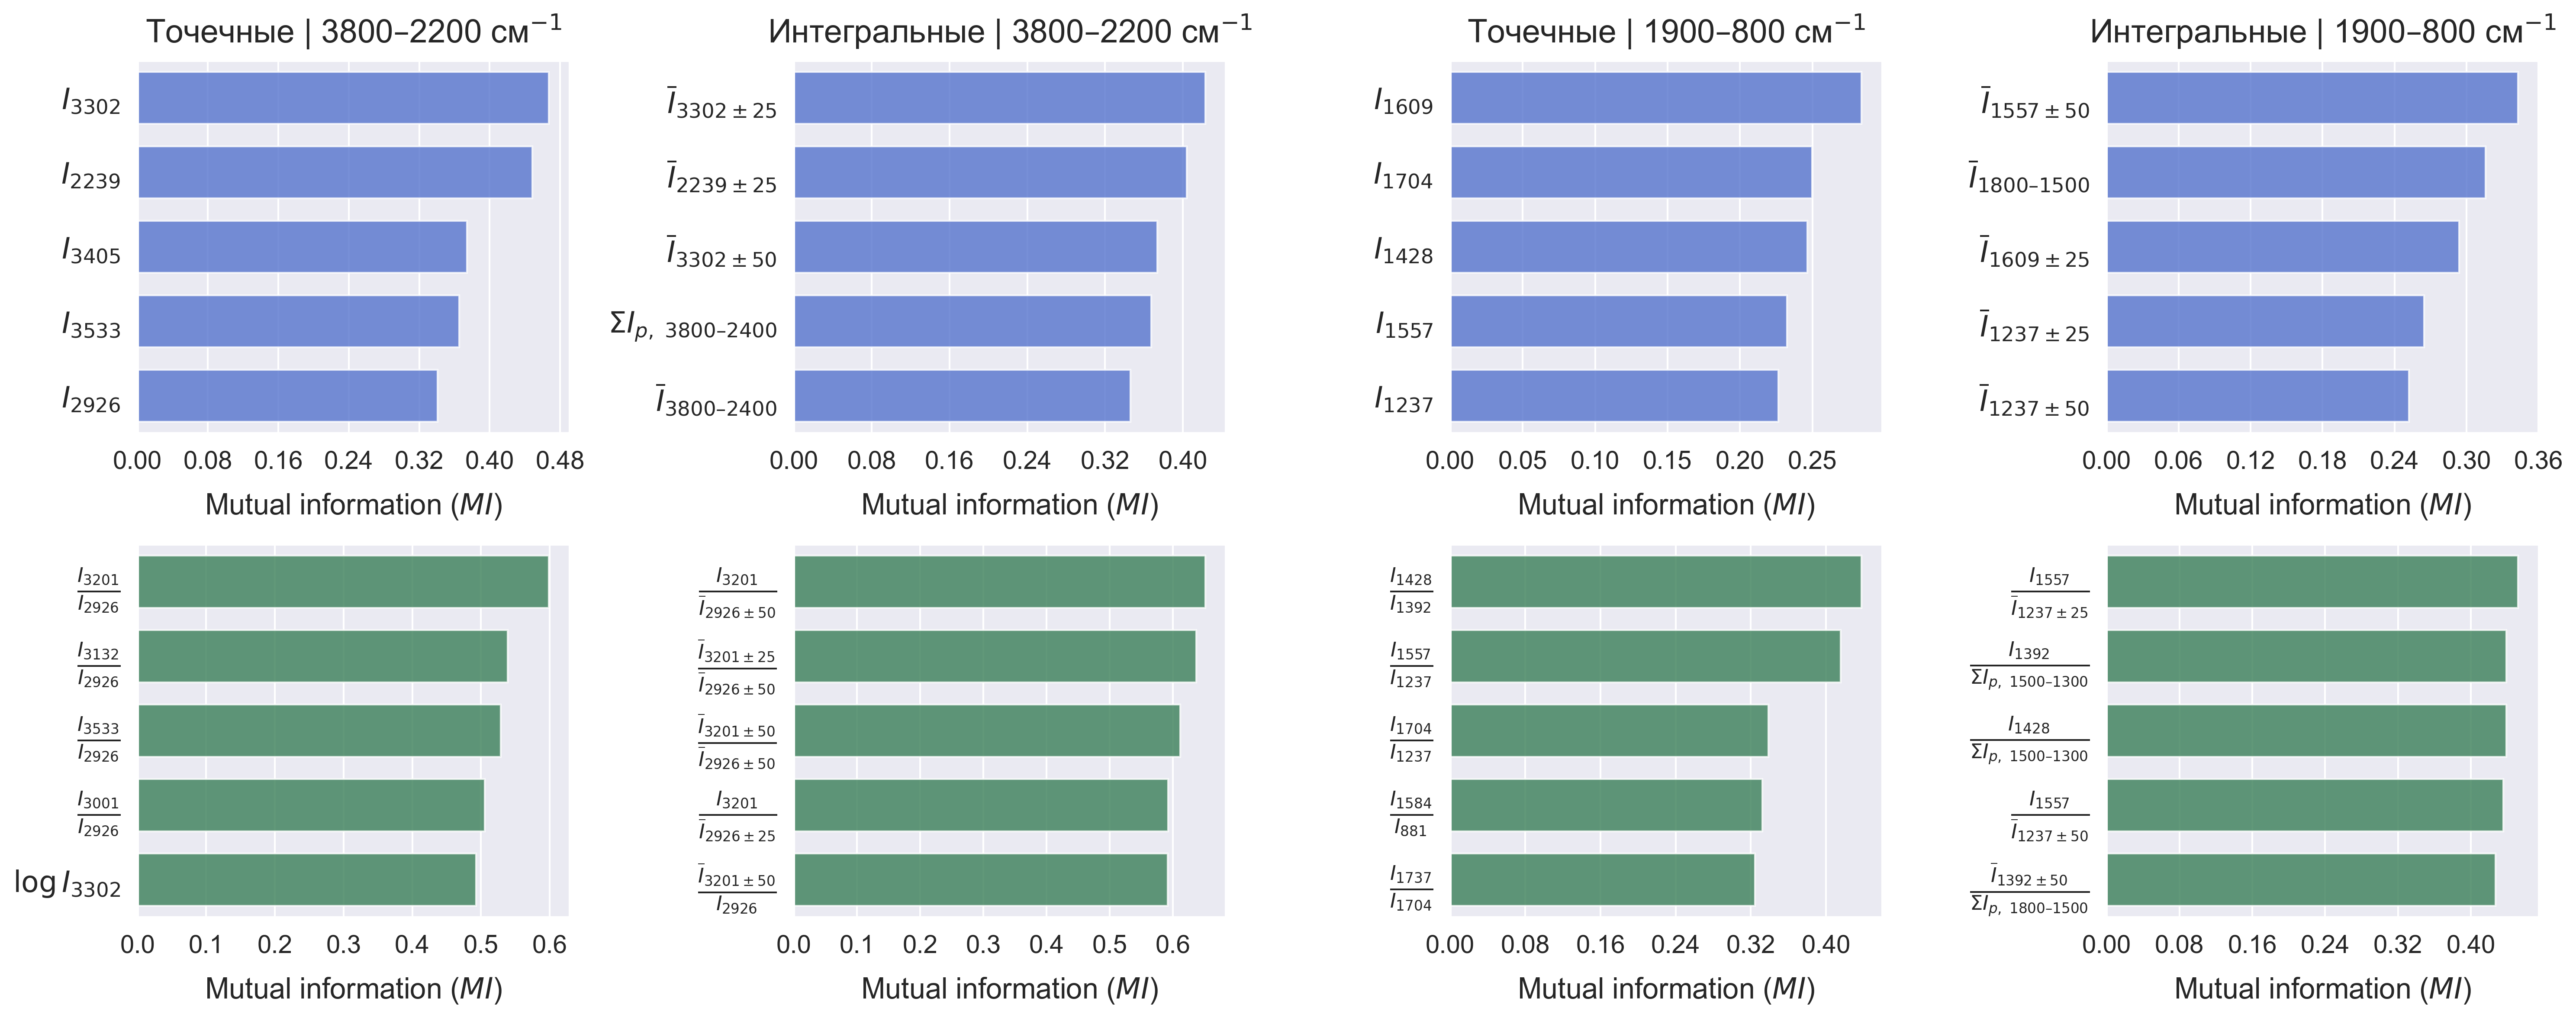

In [14]:
nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4), dpi=300)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    X_subset = features_df[features_description[feature_type]]
    y_subset = target

    mi = mutual_info_classif(X_subset, y_subset, discrete_features='auto', random_state=42)
    
    result_df = pd.DataFrame({
        'Feature': X_subset.columns,
        'Mutual_Info': mi
    })
    result_df = result_df.sort_values(by='Mutual_Info', ascending=False).head(5)

    ax = axes[i]
    
    kind = 'engineered' if 'engineered' in feature_type else 'base'
    plot_color = COLORS[kind]

    sns.barplot(
        data=result_df,
        x='Mutual_Info',
        y='Feature',
        ax=ax,
        color=plot_color,
        width=0.7,
        alpha=0.8
    )

    if i < 4:
        key = '_'.join(feature_type.split('_')[2:])
        ax.set_title(TITLE_MAP[key], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=10)
        ax.set_xlabel('')
    
    ax.set_xlabel('Mutual information ($MI$)', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/mutual_info_barplots.png', dpi=600)

plt.show()

## Visualization (BoxPlot & ViolinPlot)

In [15]:
base_feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800'
]

engineered_feature_types = [
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

### Function for sorting by *MS*

In [16]:
def get_ranked_features_by_mutual_info(features_df, target, features_description, feature_types):
    results_lst = []
    
    for feature_type in feature_types:
        X = features_df[features_description[feature_type]]
        mi = mutual_info_classif(X, target, discrete_features='auto', random_state=42)
        
        data = pd.DataFrame({
            'Feature': X.columns,
            'Mutual_Info': mi,
            'Feature_Type': feature_type
        })
        data = data.sort_values('Mutual_Info', ascending=False).reset_index(drop=True)
        
        results_lst.append(data)

    result_data = pd.concat(results_lst, ignore_index=True)
    return result_data

### *Base* features

#### Ranking features

In [17]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=base_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(95, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3302}$     0.467315  base_features_peaks_3800_2200
1  $I_{2239}$     0.448618  base_features_peaks_3800_2200
2  $I_{3405}$     0.374167  base_features_peaks_3800_2200

In [18]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3302}$     0.467315  base_features_peaks_3800_2200
1  $I_{2239}$     0.448618  base_features_peaks_3800_2200
2  $I_{3405}$     0.374167  base_features_peaks_3800_2200

In [19]:
top_features = top_features_df['Feature']

#### Data preparation

In [20]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$I_{3302}$  $I_{2239}$  $I_{3405}$  \
division_1_size_bulk    1.000000    0.118391    0.938564   
division_1_size_5       0.942571    0.123498    1.000000   
division_1_size_3       0.937402    0.126319    1.000000   

                      $\overline{I}_{3302 \pm 25}$  \
division_1_size_bulk                      0.967122   
division_1_size_5                         0.941360   
division_1_size_3                         0.935431   

                      $\overline{I}_{2239 \pm 25}$  \
division_1_size_bulk                      0.117268   
division_1_size_5                         0.122796   
division_1_size_3                         0.124977   

                      $\overline{I}_{3302 \pm 50}$  $I_{1609}$  $I_{1704}$  \
division_1_size_bulk                      0.963302         1.0    0.423317   
division_1_size_5                         0.940593         1.0    0.417765   
division_1_size_3                         0.933702         1.0    0.408867   

                      $I_{1428}$  $\overline{I}_{1557 \pm 50}$  \
division_1_size_bulk    0.682168                      0.547585   
division_1_size_5       0.621557                      0.509768   
division_1_size_3       0.644534                      0.612807   

                      $\overline{I}_{1800\text{–}1500}$  \
division_1_size_bulk                           0.531343   
division_1_size_5                              0.512855   
division_1_size_3                              0.539211   

                      $\overline{I}_{1609 \pm 25}$  target             hue  
division_1_size_bulk                      0.928269       2         $d > 5$  
division_1_size_5                         0.918881       1  $2 < d \leq 5$  
division_1_size_3                         0.945161       1  $2 < d \leq 5$

In [21]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [22]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

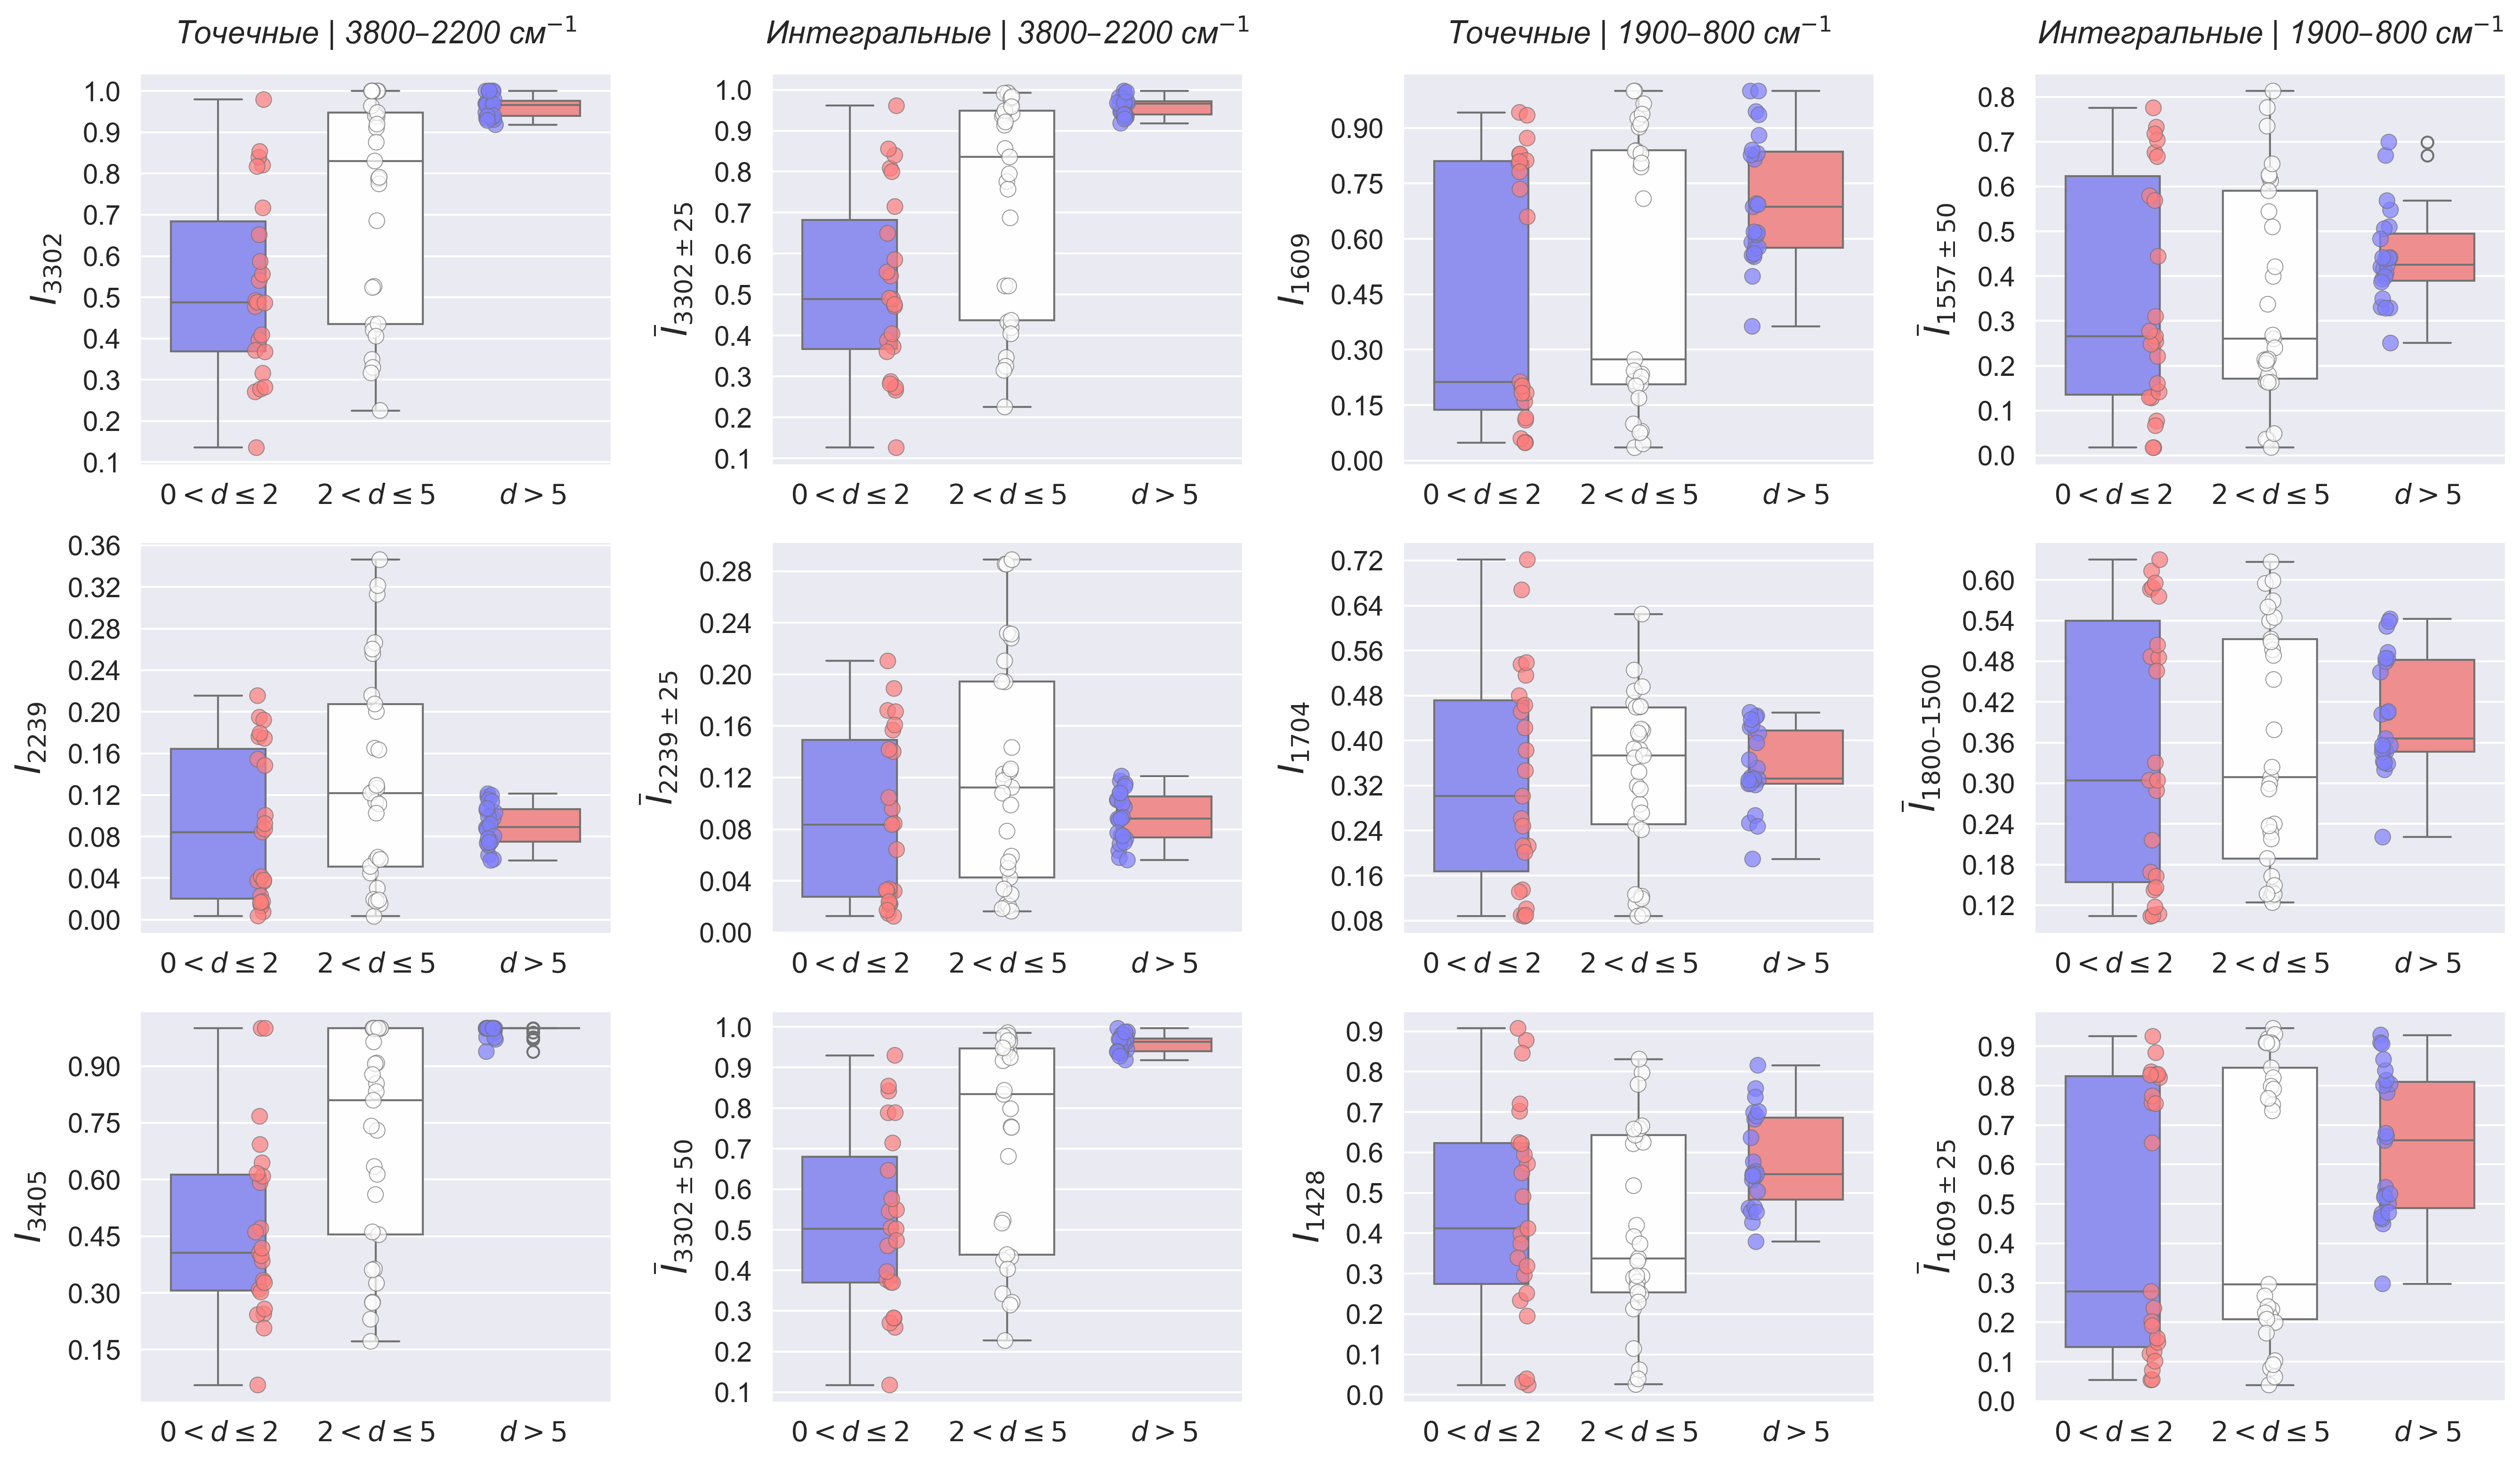

In [23]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_base_features.png', dpi=600)

plt.show()

#### Violin plot

In [24]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


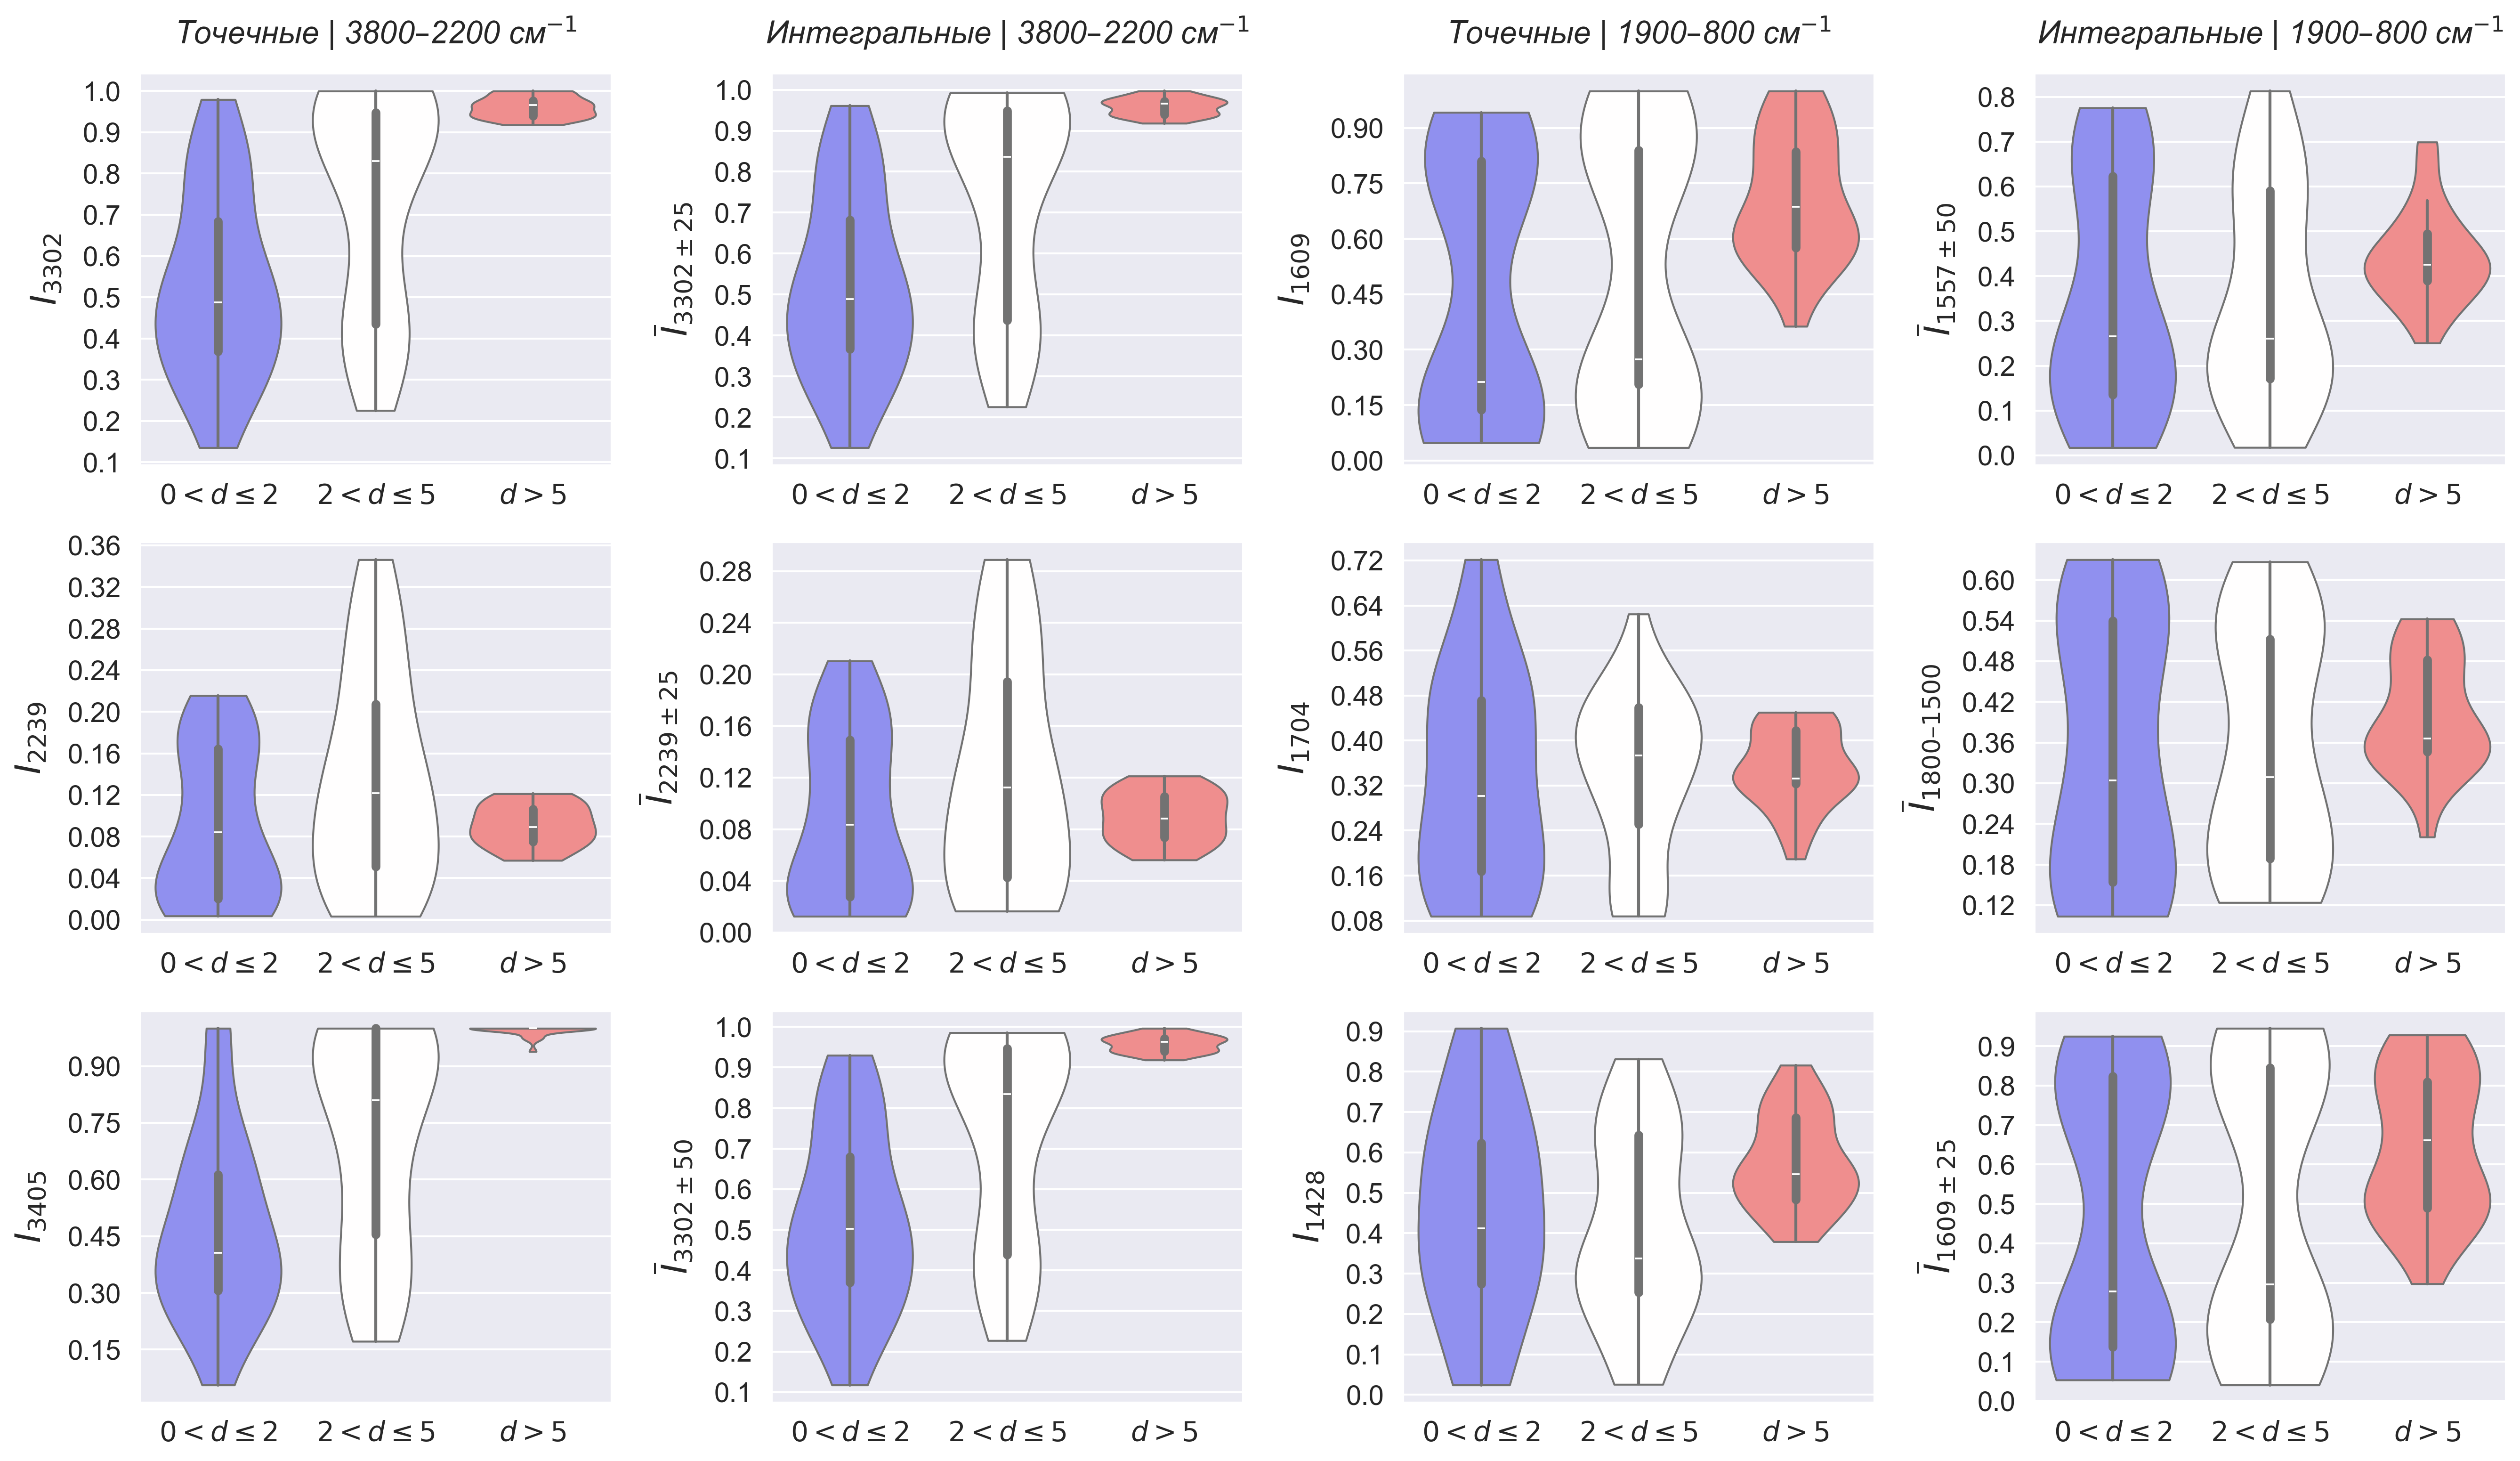

In [25]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_base_features.png', dpi=600)

plt.show()

### *Engineered* features

#### Ranking features

In [26]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=engineered_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(2456, 3)


Feature  Mutual_Info  \
0  $\frac{I_{3201}}{I_{2926}}$     0.598874   
1  $\frac{I_{3132}}{I_{2926}}$     0.538959   
2  $\frac{I_{3533}}{I_{2926}}$     0.528782   

                          Feature_Type  
0  engineered_features_peaks_3800_2200  
1  engineered_features_peaks_3800_2200  
2  engineered_features_peaks_3800_2200

In [27]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info  \
0  $\frac{I_{3201}}{I_{2926}}$     0.598874   
1  $\frac{I_{3132}}{I_{2926}}$     0.538959   
2  $\frac{I_{3533}}{I_{2926}}$     0.528782   

                          Feature_Type  
0  engineered_features_peaks_3800_2200  
1  engineered_features_peaks_3800_2200  
2  engineered_features_peaks_3800_2200

In [28]:
top_features = top_features_df['Feature']

#### Data preparation

In [29]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$\frac{I_{3201}}{I_{2926}}$  \
division_1_size_bulk                     1.928862   
division_1_size_5                        1.814598   
division_1_size_3                        1.388210   

                      $\frac{I_{3132}}{I_{2926}}$  \
division_1_size_bulk                     1.705383   
division_1_size_5                        1.570038   
division_1_size_3                        1.163609   

                      $\frac{I_{3533}}{I_{2926}}$  \
division_1_size_bulk                     1.199078   
division_1_size_5                        1.453303   
division_1_size_3                        1.092328   

                      $\frac{I_{3201}}{\overline{I}_{2926 \pm 50}}$  \
division_1_size_bulk                                       1.917057   
division_1_size_5                                          1.854238   
division_1_size_3                                          1.495384   

                      $\frac{\overline{I}_{3201 \pm 25}}{\overline{I}_{2926 \pm 50}}$  \
division_1_size_bulk                                                         1.926070   
division_1_size_5                                                            1.856151   
division_1_size_3                                                            1.500341   

                      $\frac{\overline{I}_{3201 \pm 50}}{\overline{I}_{2926 \pm 50}}$  \
division_1_size_bulk                                                         1.933650   
division_1_size_5                                                            1.854048   
division_1_size_3                                                            1.503167   

                      $\frac{I_{1428}}{I_{1392}}$  \
division_1_size_bulk                     0.832070   
division_1_size_5                        0.841809   
division_1_size_3                        0.871036   

                      $\frac{I_{1557}}{I_{1237}}$  \
division_1_size_bulk                     0.898957   
division_1_size_5                        0.894772   
division_1_size_3                        1.239632   

                      $\frac{I_{1704}}{I_{1237}}$  \
division_1_size_bulk                     0.769574   
division_1_size_5                        0.820848   
division_1_size_3                        0.859821   

                      $\frac{I_{1557}}{\overline{I}_{1237 \pm 25}}$  \
division_1_size_bulk                                       0.908412   
division_1_size_5                                          0.897143   
division_1_size_3                                          1.231288   

                      $\frac{I_{1392}}{\Sigma I_{p,\ 1500\text{–}1300}}$  \
division_1_size_bulk                                            0.545831   
division_1_size_5                                               0.542945   
division_1_size_3                                               0.534463   

                      $\frac{I_{1428}}{\Sigma I_{p,\ 1500\text{–}1300}}$  \
division_1_size_bulk                                            0.454169   
division_1_size_5                                               0.457055   
division_1_size_3                                               0.465537   

                      target             hue  
division_1_size_bulk       2         $d > 5$  
division_1_size_5          1  $2 < d \leq 5$  
division_1_size_3          1  $2 < d \leq 5$

In [30]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [31]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

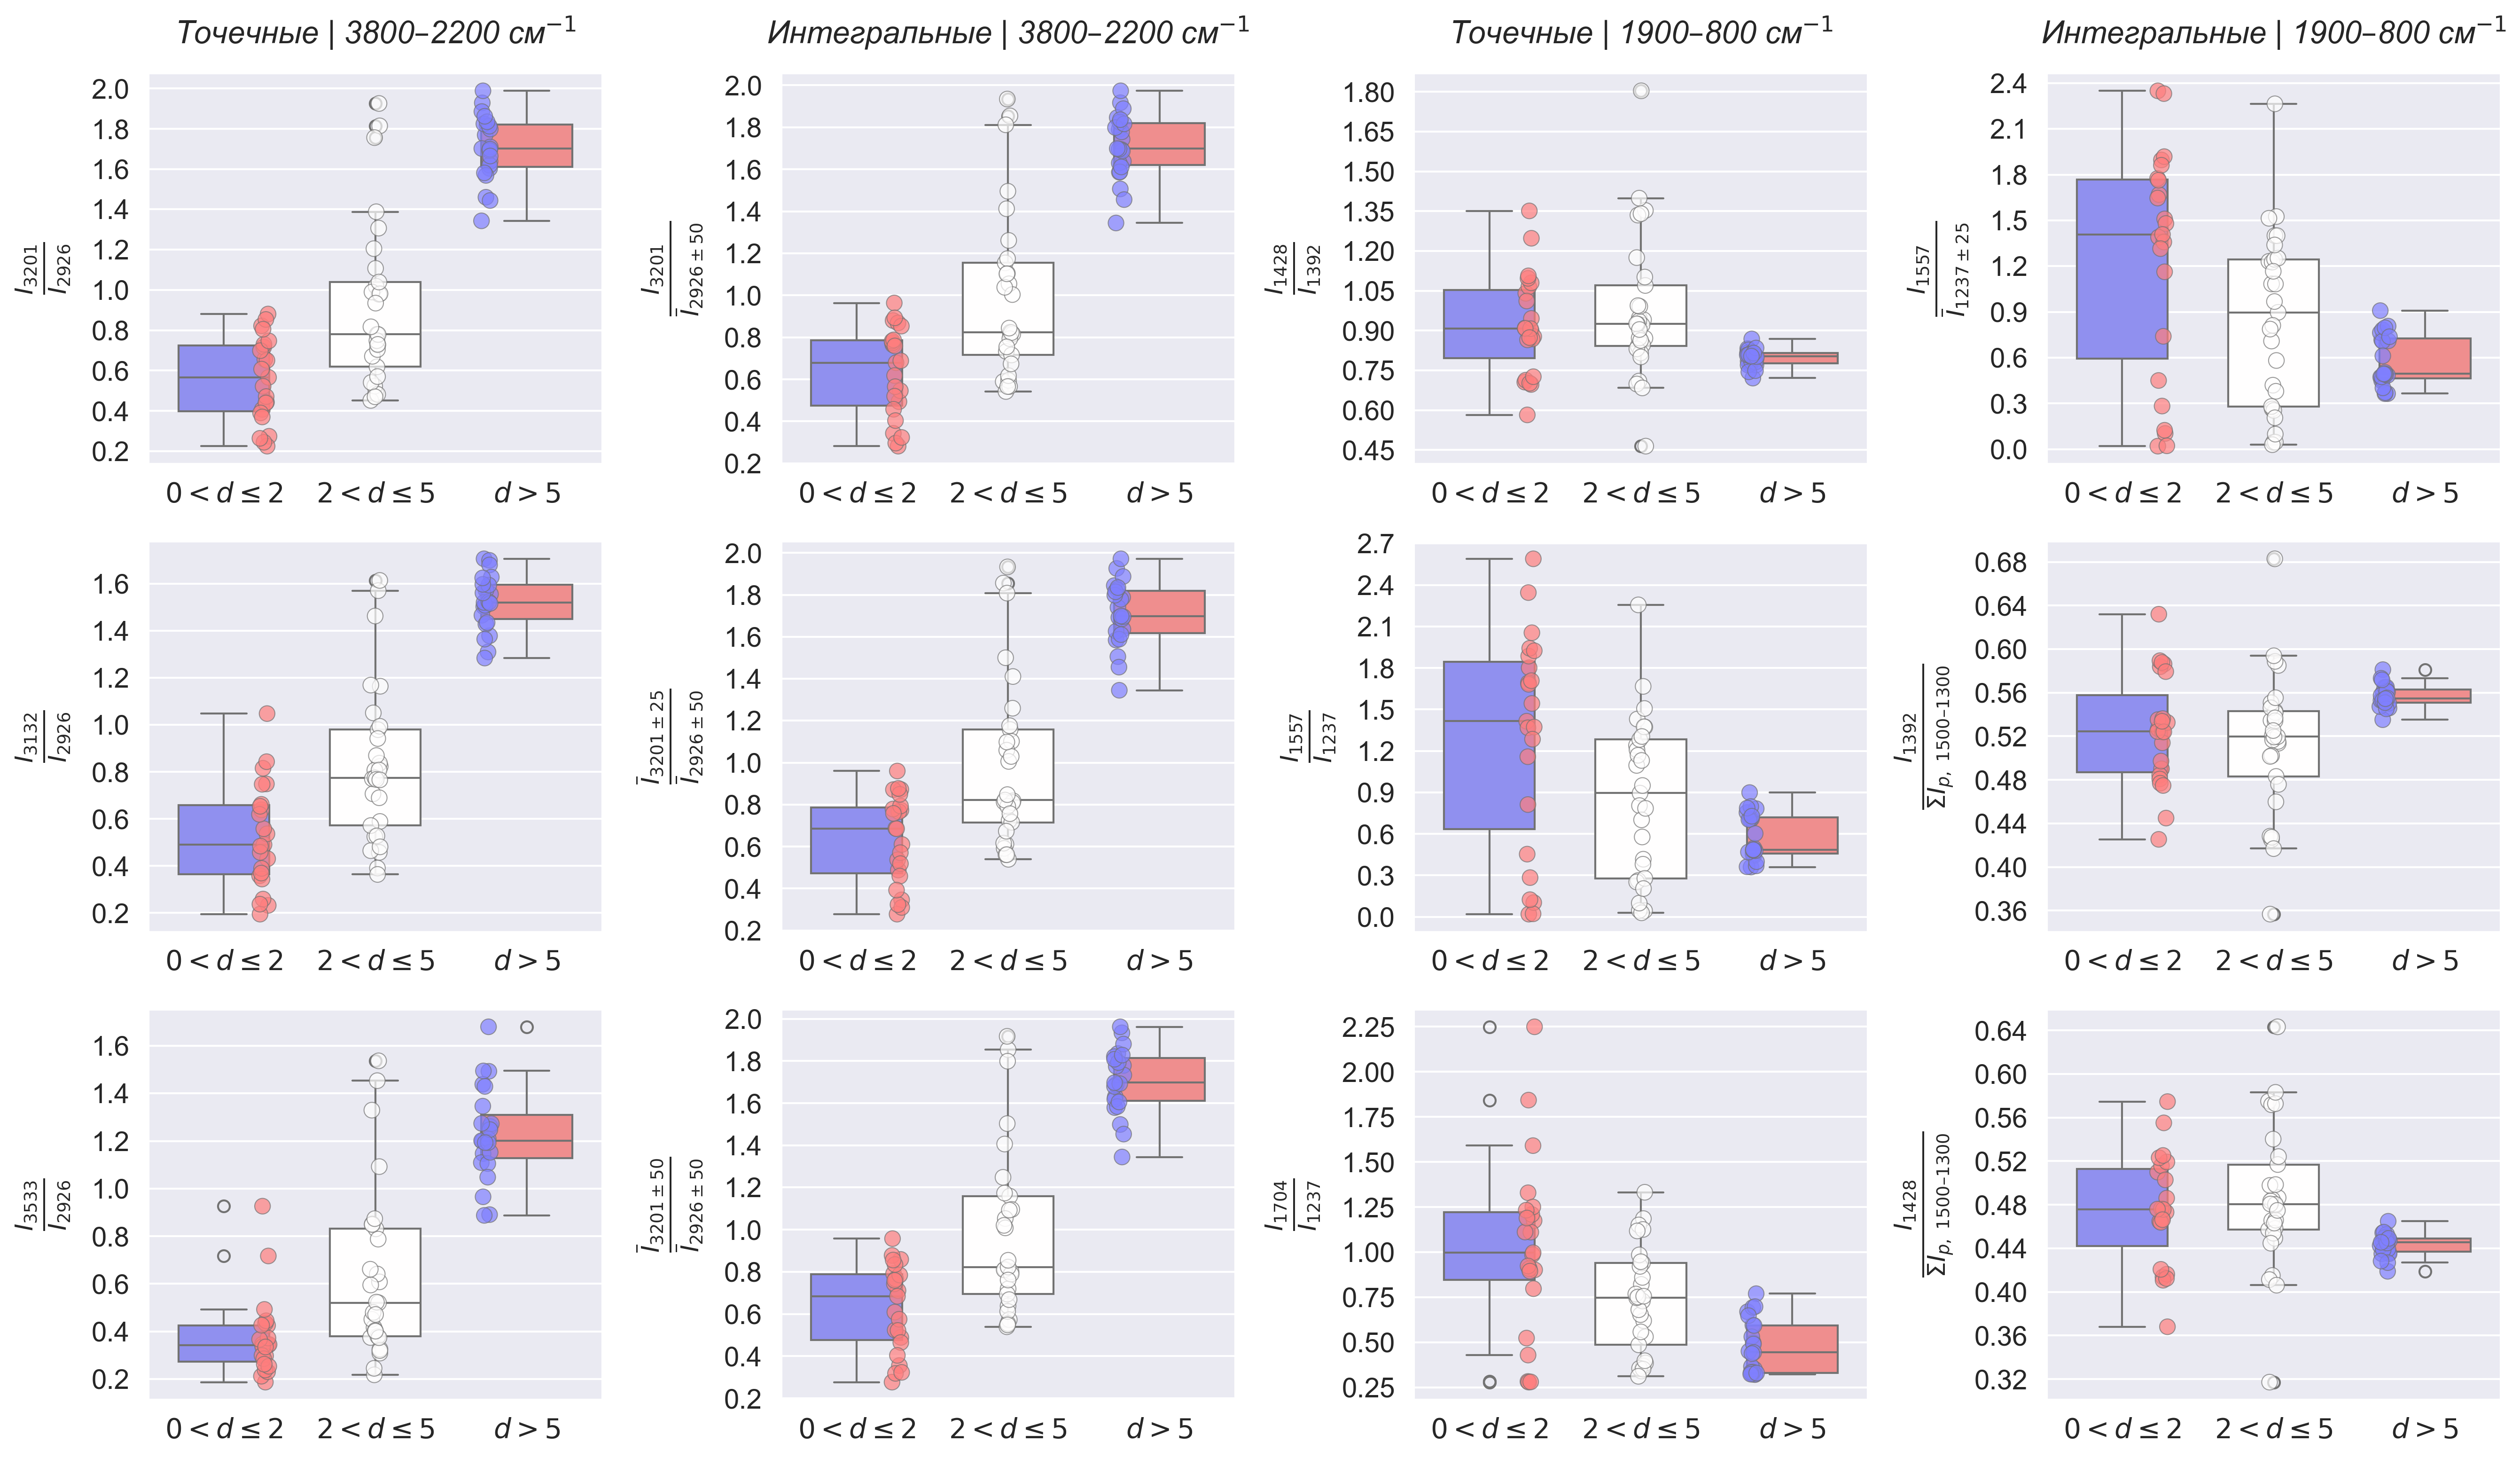

In [32]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_engineered_features.png', dpi=600)

plt.show()

#### Violin plot

In [33]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


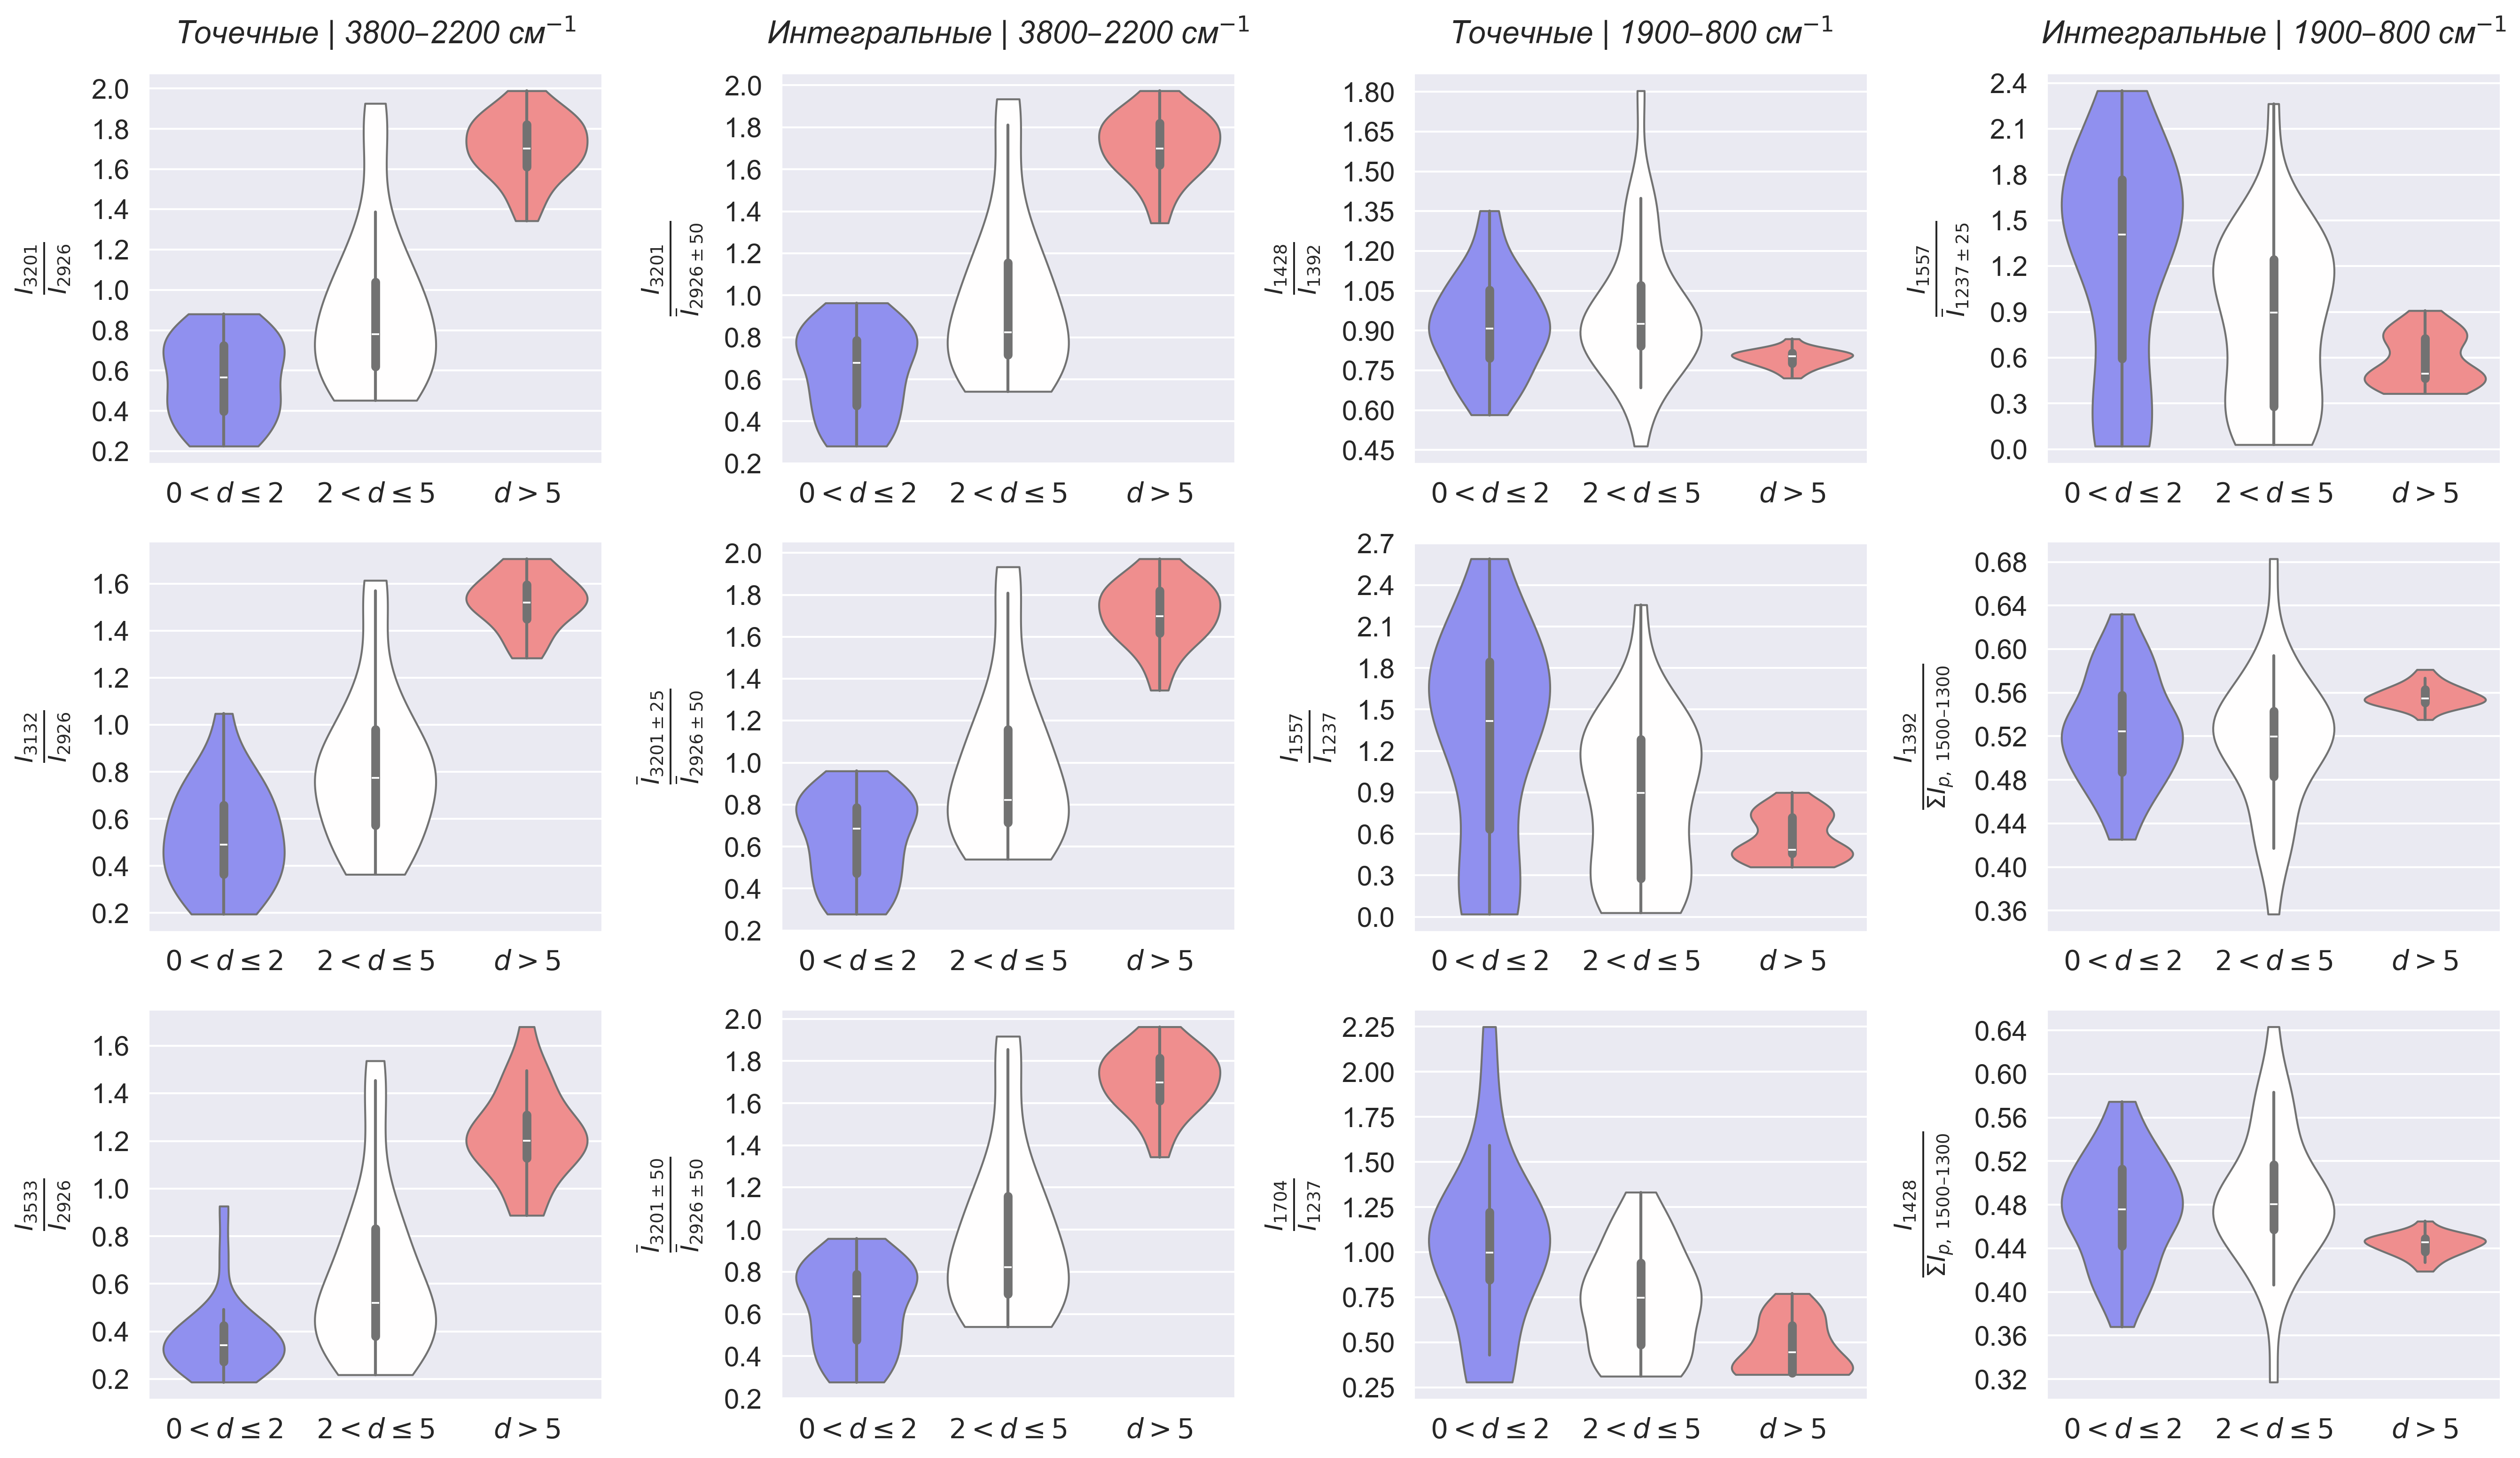

In [34]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_engineered_features.png', dpi=600)

plt.show()